In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob, os, sys
import statsmodels.api as sm
import pandas as pd

In [27]:
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_size('small')

This meta file includes data with the cut MOON_ALT>0 and SUN_ALT<-18

In [12]:
meta = np.load("/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/moon_meta_rich.npy")

In [56]:
meta.dtype.names

('PLATE',
 'SPECNO',
 'IMG',
 'FIB',
 'XFOCAL_x',
 'YFOCAL_x',
 'FIBER_RA',
 'FIBER_DEC',
 'MJD',
 'TAI-BEG',
 'TAI-END',
 'RA',
 'DEC',
 'CAMERAS',
 'AIRMASS',
 'ALT',
 'AZ',
 'EXPTIME',
 'SEEING20',
 'SEEING50',
 'SEEING80',
 'AIRTEMP',
 'DEWPOINT',
 'DUSTA',
 'DUSTB',
 'WINDD25M',
 'WINDS25M',
 'GUSTD',
 'GUSTS',
 'HUMIDITY',
 'PRESSURE',
 'WINDD',
 'WINDS',
 'MOON_LAT',
 'MOON_LON',
 'SUN_LAT',
 'SUN_LON',
 'MOON_ALT',
 'MOON_AZ',
 'SUN_ALT',
 'SUN_AZ',
 'MOON_D',
 'MOON_SEP',
 'SUN_MOON_SEP',
 'SUN_ELONG',
 'DAYS2FULL',
 'ECL_LAT',
 'ECL_LON',
 'GAL_LAT',
 'GAL_LON',
 'AZ_CALC',
 'FLI',
 'SEASON',
 'HOUR',
 'SOLARFLUX',
 'QUALITY',
 'XFOCAL_y',
 'YFOCAL_y',
 'THROUGHPUT')

Get the spframe files associated with these files

In [13]:
spframe_dir = spframe_dir = "/Volumes/PFagrelius_Backup/sky_data/sky_flux/"

In [34]:
def get_data(get_outliers = False):
    """This function finds the spframe files that will be used given the information in the meta data file. This
    function also identifies all plates that will be used by running through an outliers loop. This finds plates
    that have a dispersion in sky values greater than 1, usually corresponding to very hight continuum values that don't
    quite make sense. It creates self.avail_plates which is used in get_cont.
    """
    spframe_files = glob.glob(spframe_dir+"/*_calibrated_sky.npy")
    spframe_plates = np.array([int(filen[-23:-19]) for filen in spframe_files])

    plates = np.unique(meta['PLATE'])[0:-5]
    plates = [x for x in plates if x != '7339'] #This ones has a weird behaviour

    #If use get_outliers it will run through get_cont and only pick out plates that have a low std of continuum values.
    if get_outliers:
        avail_plates = np.intersect1d(plates, spframe_plates)
        bad_plates = get_cont(avail_plates, find_outliers = True)
        np.save('bad_plates', bad_plates)

        good_plates = []
        for plate in plates:
            if int(plate) not in bad_plates:
                good_plates.append(plate)        
        avail_plates = np.intersect1d(good_plates, spframe_plates)

    #IF you have already gone through the outliers and want to save time, you can just put them as a list here.
    else:
        bad_plates = np.load('bad_plates.npy')
        good_plates = []
        for plate in plates:
            if int(plate) not in bad_plates:
                good_plates.append(plate)
        avail_plates = np.intersect1d(good_plates, spframe_plates)
        
    return avail_plates

In [22]:
def get_cont(avail_plates, find_outliers = False):
    """This function measures the mean continuum value in the windown given in the initialization. It also saves
    this value and the meta data in a file moon_data.npy
    """
    lower = 460
    upper = 480
    mdtype = [('SKY_VALUE', 'f8'),('MOON_ALT','f8'),('MOON_SEP','f8'),('AIRMASS', 'f8'),('DAYS2FULL', 'f8'),('TIME', 'f8')]
    moon_data = []
    all_std = []
    for plate in avail_plates:
        try:
            data = np.load(spframe_dir+"%d_calibrated_sky.npy"%plate)
            plate_means = []

            plate_meta = meta[meta['PLATE'] == plate]
            blue_meta = plate_meta[(plate_meta['CAMERAS'] == b'b1') | (plate_meta['CAMERAS'] == b'b2')]
            for specno in np.unique(blue_meta['SPECNO']):
                this_meta = blue_meta[blue_meta['SPECNO'] == specno]
                idx = np.where((data[specno]['WAVE']>lower)&(data[specno]['WAVE']<upper))
                mean_sky_value = np.mean(data[specno]['SKY'][idx])
                plate_means.append(mean_sky_value)

                #To avoid zero values
                if mean_sky_value > 0.1:
                    #adjust days to full parameter
                    if this_meta['DAYS2FULL'] > 15:
                        days2full = this_meta['DAYS2FULL'] - 15
                    else:
                        days2full = this_meta['DAYS2FULL']
                    mdata=[mean_sky_value, this_meta['MOON_ALT'], this_meta['MOON_SEP'], this_meta['AIRMASS'], days2full,this_meta['TAI-BEG']]
                    moon_data.append(tuple(mdata))

            all_std.append([plate, np.std(plate_means)])
        except:
            pass

    np.save('moon_data',np.array(moon_data,dtype=mdtype))

    outliers = np.where(np.array(all_std)[:,1] > 1)
    if find_outliers:
        return np.array(all_std)[outliers][:,0]

In [23]:
def data_histograms():
    """This function plots histograms of the parameters
    """
    data = np.load('moon_data.npy')
    df = pd.DataFrame(data)
    print("Number of data points: ", len(data))

    for feat in ['MOON_ALT', 'MOON_SEP', 'AIRMASS', 'DAYS2FULL']:
        plt.figure()
        df[feat].hist(bins=20, alpha = 0.5) #,facecolor = 'blue', alpha = 0.5)
        plt.title(feat, fontproperties = font)
        plt.savefig('%s_brightsky.png'%feat)

In [24]:
def plot_linear_relations():
    data = np.load('moon_data.npy')

    for feat in ['MOON_ALT', 'MOON_SEP', 'AIRMASS','DAYS2FULL']:
        plt.figure()
        plt.plot(data[feat], data['SKY_VALUE'], '.')
        plt.title("Mean Continuum Level at 460nm vs. %s" % feat, fontproperties = font)
        plt.ylabel("Flux $10^{-17} erg/cm^{2}/s/\AA$", fontproperties = font)
        if (feat == 'MOON_ALT') | (feat == 'MOON_SEP'):
            plt.xlabel("Degrees",fontproperties = font)
        elif feat == 'AIRMASS':
            plt.xlabel("Airmass",fontproperties = font)
        elif feat == 'DAYS2FULL':
            plt.xlabel("Days until full moon",fontproperties = font)
        plt.savefig("%s_linear_plots.png"%feat)

In [45]:
def linear_regression():
    data = np.load('moon_data.npy')

    X = []
    for feat in ['MOON_ALT', 'MOON_SEP', 'AIRMASS','DAYS2FULL']:
        X.append(data[feat])
    X = np.column_stack(X)

    y = data['SKY_VALUE']
    print(X.shape, y.shape)

    results = sm.OLS(y, X).fit()
    params = results.params
    model = np.dot(X, params)

    print(results.summary())
    return y, model

These plots include the plates with large dispersion. I then cut any plate out with std>1.

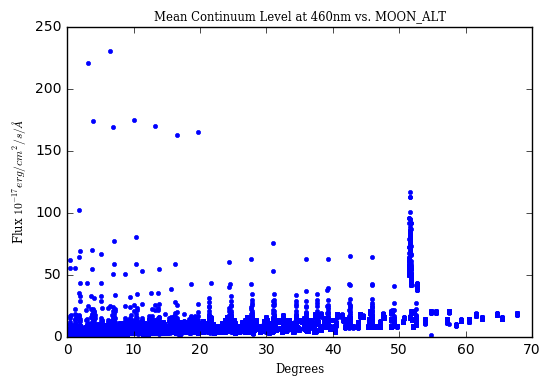

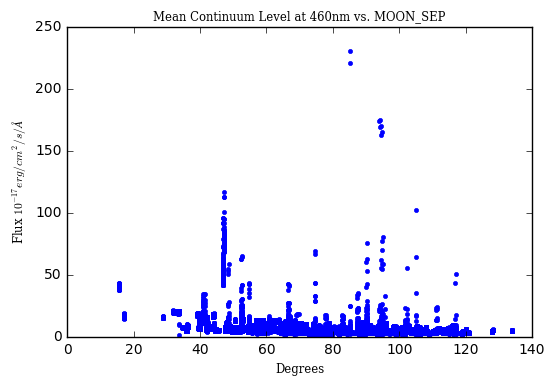

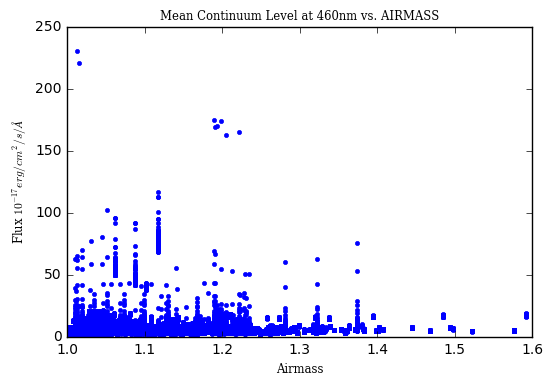

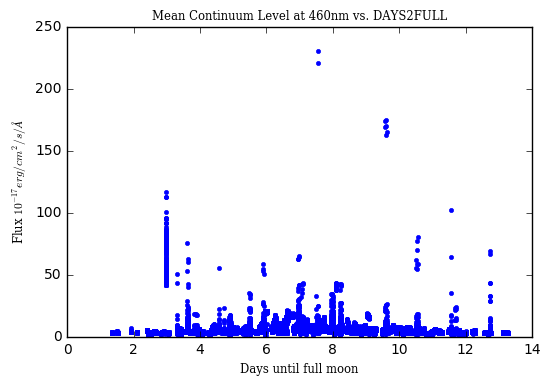

In [28]:
get_data(get_outliers = True)
plot_linear_relations()

In [36]:
avail_plates = get_data(get_outliers = False)
get_cont(avail_plates, find_outliers = False)

[ 3588.  3647.  3657.  3664.  3673.  3802.  3810.  3818.  3834.  3841.
  3847.  3960.  3977.  3987.  4024.  4052.  4075.  4346.  4695.  4709.
  4718.  4722.  4723.  4727.  4749.  4797.  4835.  4964.  5186.  5297.
  5323.  5358.  5430.  5477.  5718.  5745.  5806.  5846.  5864.  5879.
  5884.  5895.  5896.  5970.  5991.  6006.  6022.  6037.  6061.  6379.
  6435.  6455.  6468.  6618.  6619.  6828.  7044.  7096.  7123.  7240.
  7388.]
358
297


moon_data.npy has now been created and can be used in all further analyses

Number of data points:  83276


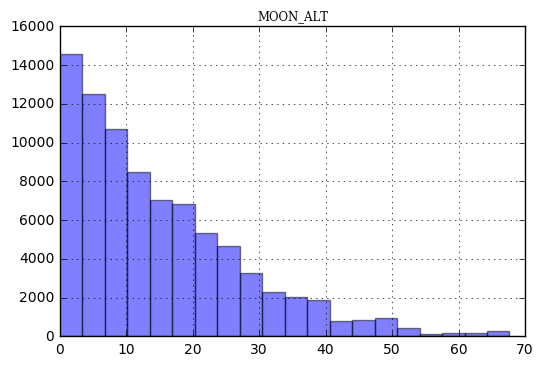

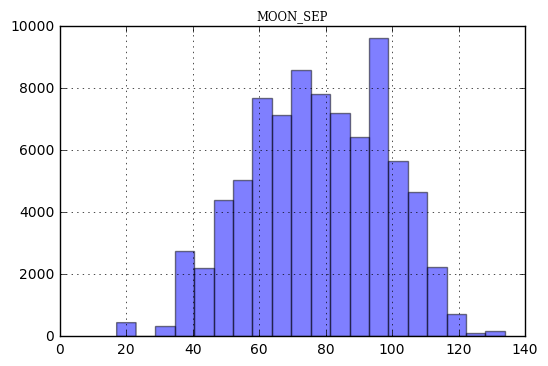

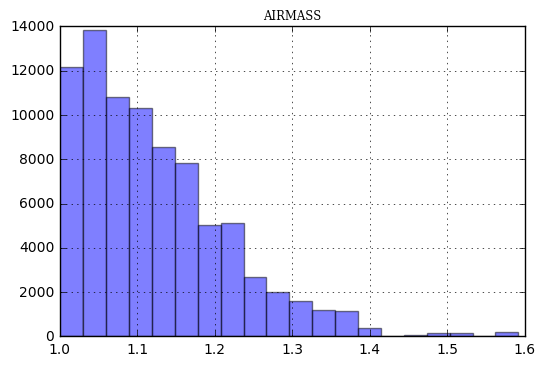

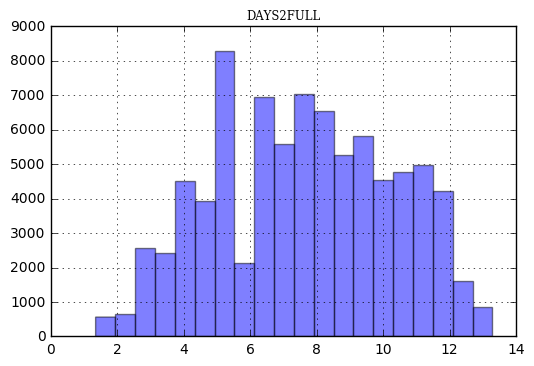

In [37]:
data_histograms()

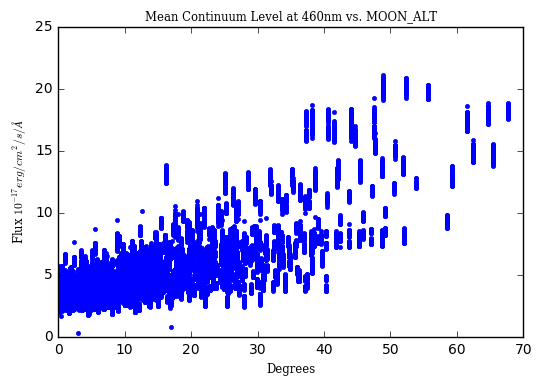

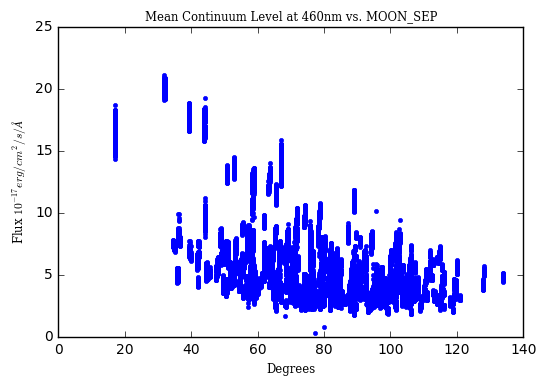

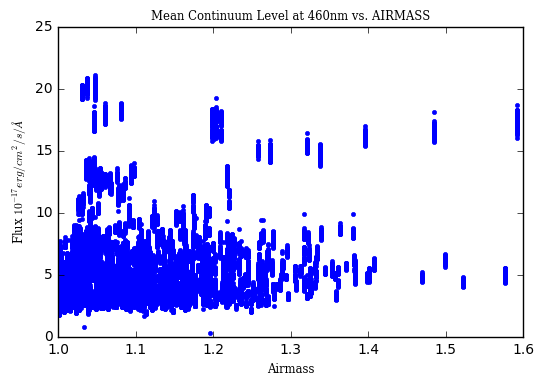

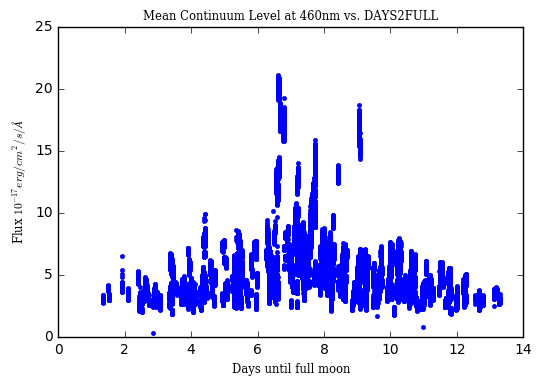

In [38]:
plot_linear_relations()

In [42]:
data, model = linear_regression()

(83276, 4) (83276,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 2.227e+05
Date:                Wed, 13 Dec 2017   Prob (F-statistic):               0.00
Time:                        17:09:40   Log-Likelihood:            -1.6529e+05
No. Observations:               83276   AIC:                         3.306e+05
Df Residuals:                   83272   BIC:                         3.306e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.1553      0.001

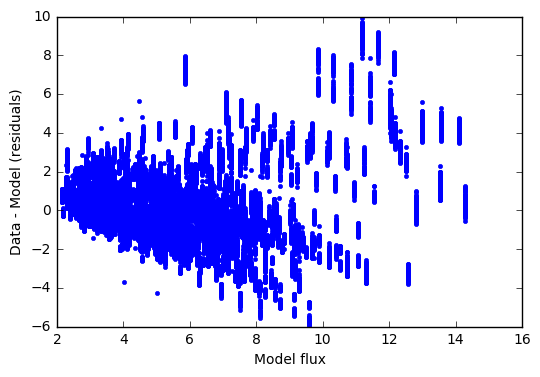

In [54]:
plt.plot(model, data-model,'.')
plt.xlabel("Model flux")
plt.ylabel("Data - Model (residuals)")